In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import random
from collections import namedtuple
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings('ignore')

In [2]:
env = gym.make('LunarLander-v2')

In [3]:
num_state = env.observation_space.shape[0]
num_action = env.action_space.n

In [4]:
class network(nn.Module):
    
    def __init__(self , num_state , num_action):
        
        super().__init__()
        self.fc1 = nn.Linear(num_state , 50 )
        self.fc2 = nn.Linear(50 , 50)
        self.out = nn.Linear(50 , num_action )
        
    def forward(self , x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

class ReplayBuffer(object):
    '''
    
    This code is copied from openAI baselines
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    '''
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes , dtype = np.float32):
        
        
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False,dtype=dtype))
            actions.append(np.array(action, copy=False,dtype=np.long))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False,dtype=dtype))
            dones.append(done)
        return np.array(obses_t,dtype=dtype), np.array(actions , dtype = np.long), \
    np.array(rewards  ,dtype=dtype), np.array(obses_tp1,dtype=dtype), np.array(dones , dtype = bool)
    
    
    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

    
class Agent():
    
    def __init__(self , num_state , num_action):
        
        
        
        self.policy_network = network(num_state , num_action)
        self.target_network = network(num_state , num_action)
        
        self.target_network.load_state_dict(self.policy_network.state_dict())
        
        self.steps_done = 0
        self.num_state = num_state
        self.num_action = num_action
        
        self.EPS_END = 0.05
        self.EPS_START = 0.999
        
        self.EPS_DECAY = 1000
        self.batch_size = 64
        self.buffer = ReplayBuffer( 4000 )
        self.optimizer = torch.optim.Adam(self.policy_network.parameters()   , amsgrad=True)
        
    def take_action(self , x , is_testing = False ) :
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        rand_val = np.random.uniform()
        if rand_val > eps_threshold or is_testing == True:
            val = self.policy_network(x)
            action = torch.argmax(val).item()
            
            
        else:
            action = np.random.randint(0 , self.num_action )
        
        if is_testing == False:
            self.steps_done += 1
        
        return action
            
    
    def store_transition(self, state , action , reward , next_state , done ):
        
        self.buffer.add(state , action , reward , next_state , done)
    
    def update_parameters(self):
        
        if len(self.buffer) < self.batch_size:
            return 
        
        loss_fn = torch.nn.MSELoss(reduction = 'mean')
        
        batch = self.buffer.sample(self.batch_size)
        states , actions , rewards , next_states , dones = batch
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions).view(-1,1)
        rewards = torch.from_numpy(rewards)
        next_states = torch.from_numpy(next_states)
        actions = actions.long()
        
        non_final_mask = torch.tensor(tuple(map(lambda s : s != True, dones)),dtype = torch.bool)
        non_final_next_state = next_states[non_final_mask]
        
        
        pred_q = self.policy_network(states).gather(1 , actions).view(-1) 
        
        
        next_state_value = torch.zeros(self.batch_size).detach()
        next_state_value[non_final_mask] = self.target_network(non_final_next_state).max(1)[0]
        expected_q = (next_state_value + rewards).detach()
        
        
        loss = loss_fn(pred_q , expected_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_weight(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())


In [5]:
from PIL import Image
import time
def get_snap_shot(agent  , env_name = 'LunarLander-v2' , gif_filename = None):
    try:
        
        if gif_filename != None:
            frames = []
        
        env = gym.make(env_name)
        state = env.reset()
        done = False
        rew_sum = 0.0
        while done == False:
            if gif_filename != None:
                frames.append(Image.fromarray(env.render(mode='rgb_array')))
            else:
                env.render()
            action = agent.take_action(state , is_testing = True)
            next_state , reward , done , _ = env.step(action)
            rew_sum += reward
            state = next_state[:]
        print('total reward',rew_sum)
        
        if gif_filename != None:
            with open(gif_filename,'wb') as f:
                im = Image.new('RGB', frames[0].size)
                im.save(f, save_all=True, append_images=frames)
        time.sleep(1.5) #Prevent kernel dead
        
    finally:
        env.close()
        
        

In [12]:
agent = Agent(num_state , num_action)
reward_history = []
try:
    env = gym.make('LunarLander-v2')
    for e in tqdm(range(1000)):
        state = env.reset()
        done = False
        reward_sum = 0.0
        while done == False:
            
            action = agent.take_action(state)
            next_state , reward , done , _ = env.step(action)
            reward_sum += reward 
            if(state[1] >= 1.5):
                reward = reward + abs(state[3])  
            reward = reward - abs(state[1]) * 2 - abs(state[0]) 
            agent.store_transition( state , action , reward , next_state , done )
            state = next_state[:]
            agent.update_parameters()
            
        reward_history.append(reward_sum)
        if e  % 50 == 0:
            print(reward_sum)
            #get_snap_shot(agent = agent , gif_filename='cartpole_gif/episode_{}.gif'.format(e))
            #get_snap_shot(agent = agent)
        if e > 0 and e % 20 == 0:
            agent.update_target_weight()
finally:
    env.close()

-170.66530826540628
-182.6955566167171
-91.20198650807866
45.13525863088381
242.7812571415648
-237.48033290849807
-150.9300518649605
191.41928760606913
-55.991339721045705
248.11738541218065
227.30131240720175
2.5521671115871225
154.81802351158254
10.454320368960822
-111.07670809836245
-139.30777539415726
294.6183706798413
274.06878878015834
286.9725323584556
196.20402417585777



In [19]:
try:
    env = gym.make('LunarLander-v2')
    for e in tqdm(range(1)):
        state = env.reset()
        done = False
        reward_sum = 0.0
        while done == False:
            
            action = agent.take_action(state)
            next_state , reward , done , _ = env.step(action)
            reward_final = reward
            reward_sum += reward 
            if(state[1] >= 1.5):
                reward = reward + abs(state[3])  
            reward = reward - abs(state[1]) * 2 - abs(state[0]) 
            agent.store_transition( state , action , reward , next_state , done )
            state = next_state[:]
            agent.update_parameters()
            
        reward_history.append(reward_sum)
        if e  % 50 == 0:
            #print(reward_final)
            #print(reward_sum)
            get_snap_shot(agent = agent , gif_filename='result2.gif')
            #get_snap_shot(agent = agent)
        if e > 0 and e % 20 == 0:
            agent.update_target_weight()
finally:
    env.close()

total reward 267.136308838039


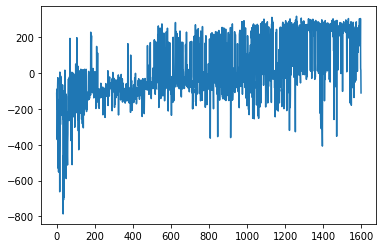

In [10]:
import matplotlib.pyplot as plt
plt.plot(reward_history)